# Assignment 2 For Clustering: Sessa Empirical Estimator

Abangan, Jaerian Peter <br>
Berbo, Chris Derek <br>
BSCS - 3

<hr>

## Using the Sessa Empircal Estimator (KMeans):

K-means Clustering Analysis

Boxplots for medA:


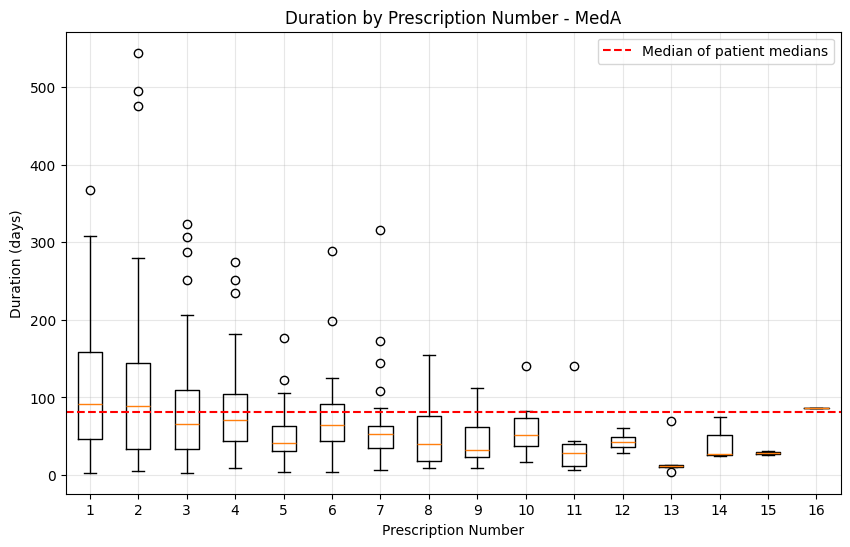


Boxplots for medB:


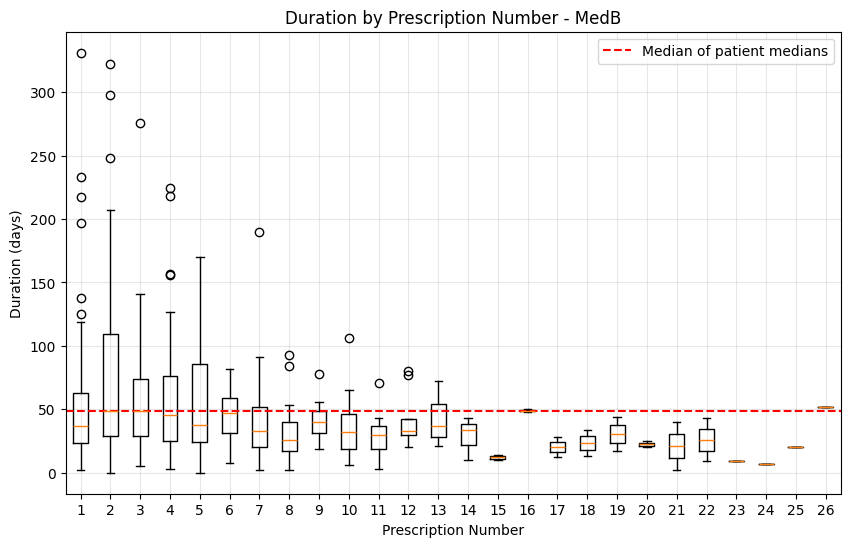


Running K-means clustering analysis...


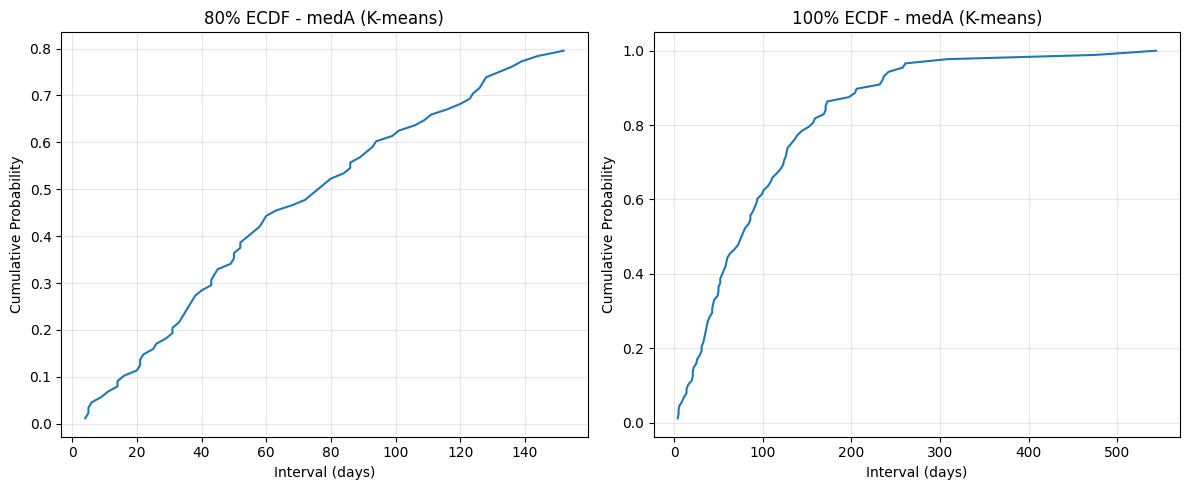

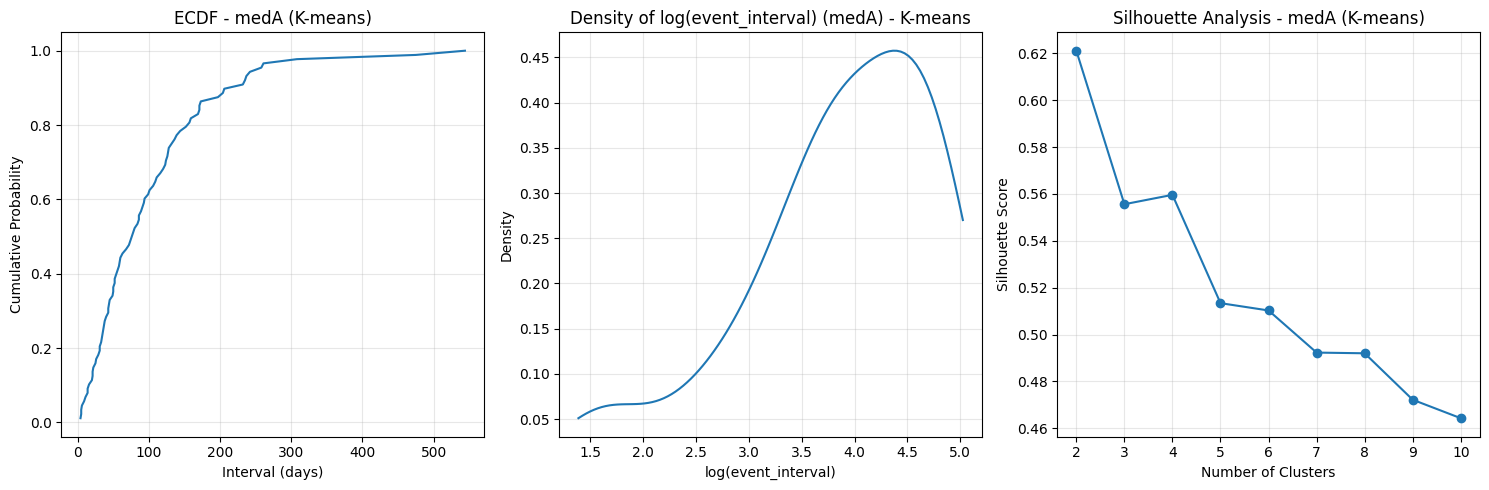

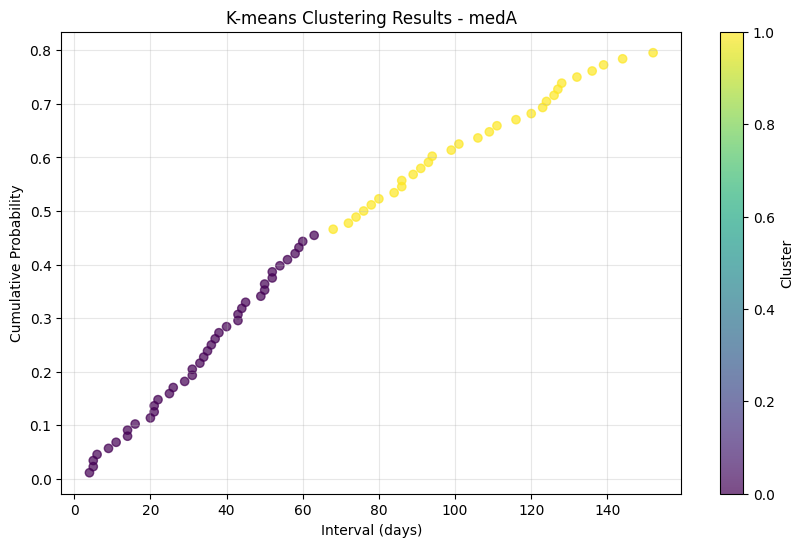

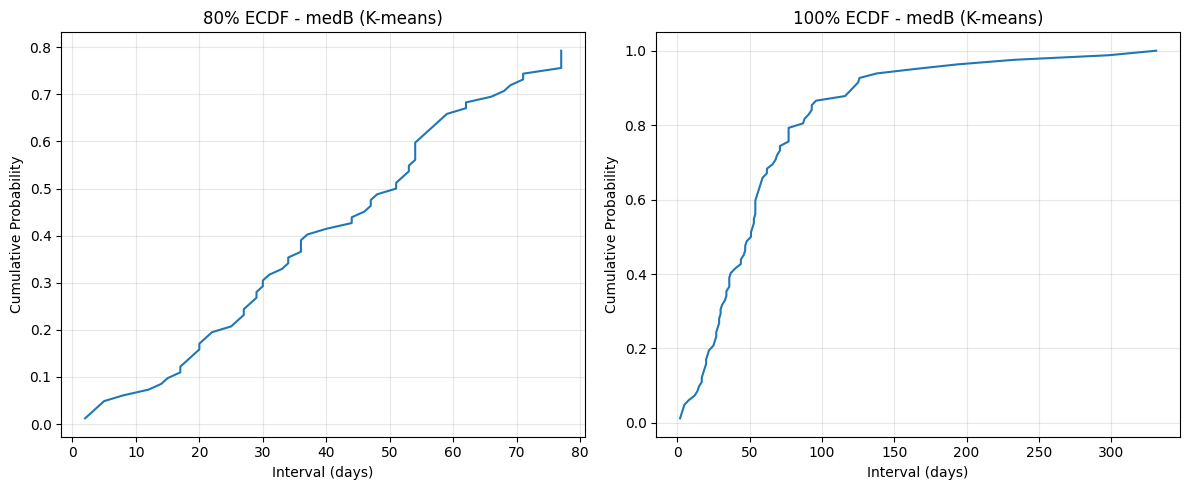

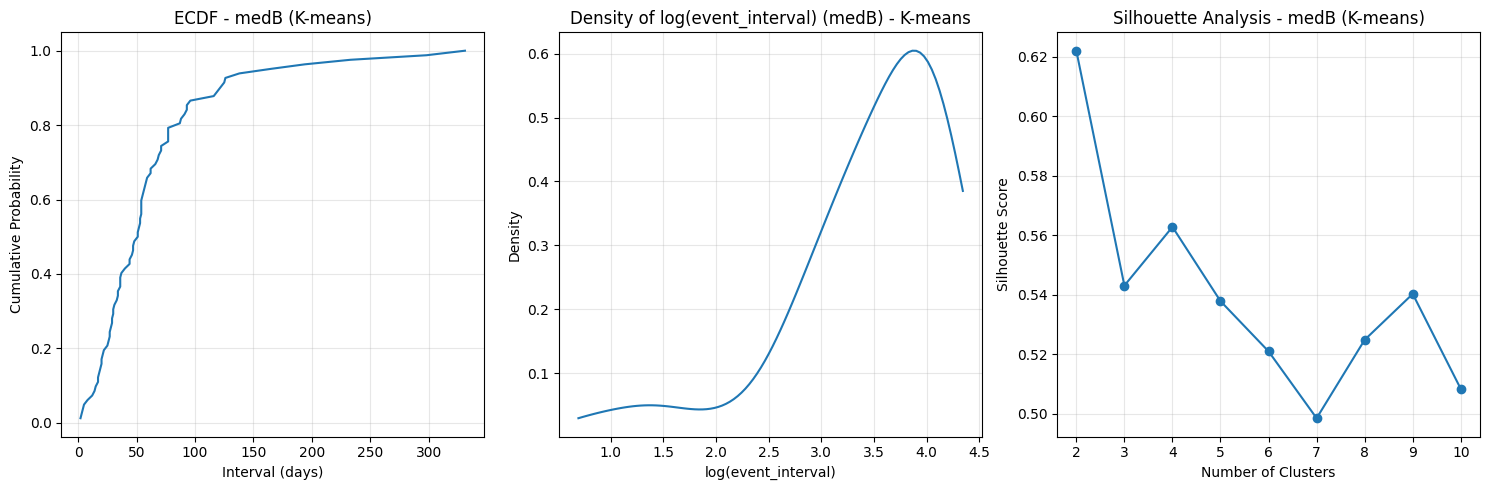

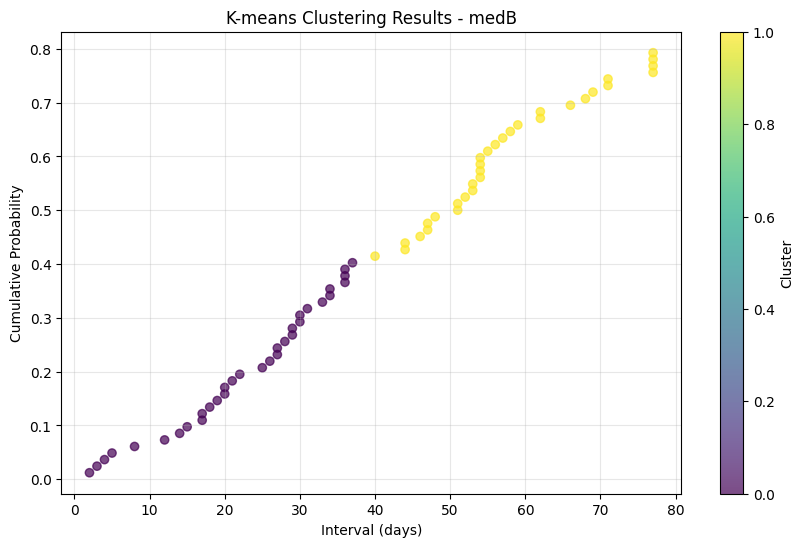

In [25]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Load data
tidy = pd.read_csv("Data/med_events.csv")
tidy.columns = ["pnr", "eksd", "perday", "ATC", "dur_original"]
tidy['eksd'] = pd.to_datetime(tidy['eksd'], format='%m/%d/%Y')

def plot_kmeans_clustering(data_scaled, arg1, dfper, x_vals, y_vals):
    """
    Plotting function for K-means method: ECDF, Density, and Silhouette
    """
    # First plot 80% and 100% ECDFs
    mask_80 = y_vals <= 0.8
    x_80 = x_vals[mask_80]
    y_80 = y_vals[mask_80]
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(x_80, y_80)
    plt.title(f"80% ECDF - {arg1} (K-means)")
    plt.xlabel("Interval (days)")
    plt.ylabel("Cumulative Probability")
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.plot(x_vals, y_vals)
    plt.title(f"100% ECDF - {arg1} (K-means)")
    plt.xlabel("Interval (days)")
    plt.ylabel("Cumulative Probability")
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Then plot analysis graphs
    plt.figure(figsize=(15, 5))
    
    # Plot ECDF
    plt.subplot(1, 3, 1)
    plt.plot(x_vals, y_vals)
    plt.title(f"ECDF - {arg1} (K-means)")
    plt.xlabel("Interval (days)")
    plt.ylabel("Cumulative Probability")
    plt.grid(True, alpha=0.3)
    
    # Plot Density
    plt.subplot(1, 3, 2)
    # Add small constant and filter out non-positive values before log transform
    positive_intervals = dfper['x'][dfper['x'] > 0]
    if len(positive_intervals) > 0:
        log_intervals = np.log(positive_intervals)
        kde = gaussian_kde(log_intervals)
        x_range = np.linspace(log_intervals.min(), log_intervals.max(), 100)
        plt.plot(x_range, kde(x_range))
    plt.title(f'Density of log(event_interval) ({arg1}) - K-means')
    plt.xlabel('log(event_interval)')
    plt.ylabel('Density')
    plt.grid(True, alpha=0.3)
    
    # Plot Silhouette
    plt.subplot(1, 3, 3)
    range_n_clusters = range(2, 11)
    silhouette_scores = []
    for n_clusters in range_n_clusters:
        kmeans = KMeans(n_clusters=n_clusters, random_state=1234)
        cluster_labels = kmeans.fit_predict(data_scaled)
        silhouette_avg = silhouette_score(data_scaled, cluster_labels)
        silhouette_scores.append(silhouette_avg)
    plt.plot(range_n_clusters, silhouette_scores, marker='o')
    plt.title(f"Silhouette Analysis - {arg1} (K-means)")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Silhouette Score")
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Plot clustered data
    plt.figure(figsize=(10, 6))
    plt.scatter(dfper['x'], dfper['y'], c=dfper['cluster'], cmap='viridis', alpha=0.7)
    plt.title(f'K-means Clustering Results - {arg1}')
    plt.xlabel('Interval (days)')
    plt.ylabel('Cumulative Probability')
    plt.colorbar(label='Cluster')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return silhouette_scores

def See(arg1="medA"):
    # Filter data for specific medication
    drug_see = tidy[tidy['ATC'] == arg1].copy()
    
    # Calculate intervals between prescriptions for each patient
    drug_see['prev_eksd'] = drug_see.groupby('pnr')['eksd'].shift(1)
    drug_see = drug_see.dropna(subset=['prev_eksd'])
    
    # Sample one interval per patient (simpler version)
    drug_see_sample = pd.DataFrame()
    for _, group in drug_see.groupby('pnr'):
        drug_see_sample = pd.concat([drug_see_sample, group.sample(n=1)])
    
    # Calculate interval in days
    drug_see_sample['event_interval'] = (
        drug_see_sample['eksd'] - drug_see_sample['prev_eksd']
    ).dt.days
    
    # Generate ECDF
    intervals = np.sort(drug_see_sample['event_interval'])
    n = len(intervals)
    y_vals = np.arange(1, n + 1) / n
    x_vals = intervals
    
    # Prepare data for clustering
    dfper = pd.DataFrame({'x': x_vals, 'y': y_vals})
    dfper = dfper[dfper['y'] <= 0.8]  # Keep only 80% of data
    
    # Scale the data
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(dfper)
    
    # Calculate silhouette scores first
    range_n_clusters = range(2, 11)
    silhouette_scores = []
    labels = None
    
    for n_clusters in range_n_clusters:
        kmeans = KMeans(n_clusters=n_clusters, random_state=1234)
        cluster_labels = kmeans.fit_predict(data_scaled)
        silhouette_avg = silhouette_score(data_scaled, cluster_labels)
        silhouette_scores.append(silhouette_avg)
        
        # Save the labels for the optimal number of clusters
        if n_clusters == range_n_clusters[np.argmax(silhouette_scores)]:
            labels = cluster_labels
    
    dfper['cluster'] = labels
    
    # Plot results
    plot_kmeans_clustering(
        data_scaled, arg1, dfper, x_vals, y_vals
    )
    
    return max(x_vals[y_vals <= 0.8]), dfper

def see_assumption(data, title=""):
    # Calculate prescription order and intervals
    data = data.copy()
    data['prev_eksd'] = data.groupby('pnr')['eksd'].shift(1)
    data['Duration'] = (data['eksd'] - data['prev_eksd']).dt.days
    
    # Create prescription number (p_number) for each patient
    data['p_number'] = data.groupby('pnr').cumcount() + 1
    
    # Filter to prescriptions >= 2 (since first prescription has no interval)
    data = data[data['p_number'] >= 2]
    
    # Calculate median duration for each patient
    medians = data.groupby('pnr')['Duration'].median()
    overall_median = medians.median()
    
    # Create boxplot
    plt.figure(figsize=(10, 6))
    bp = plt.boxplot([group['Duration'] for name, group in data.groupby('p_number')])
    
    # Add horizontal line for median of medians
    plt.axhline(y=overall_median, color='r', linestyle='--', label='Median of patient medians')
    
    plt.title(f'Duration by Prescription Number - {title}')
    plt.xlabel('Prescription Number')
    plt.ylabel('Duration (days)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return plt

# Run K-means clustering analysis and assumption checks
print("K-means Clustering Analysis")
print("\nBoxplots for medA:")
medA_data = tidy[tidy['ATC'] == "medA"].copy()
see_assumption(medA_data, "MedA")

print("\nBoxplots for medB:")
medB_data = tidy[tidy['ATC'] == "medB"].copy()
see_assumption(medB_data, "MedB")

print("\nRunning K-means clustering analysis...")
max_interval_medA_kmeans, clusters_medA_kmeans = See("medA")
max_interval_medB_kmeans, clusters_medB_kmeans = See("medB")

## Using different Clustering Algorithm (DBSCAN)

DBSCAN Clustering Analysis

Running DBSCAN analysis...


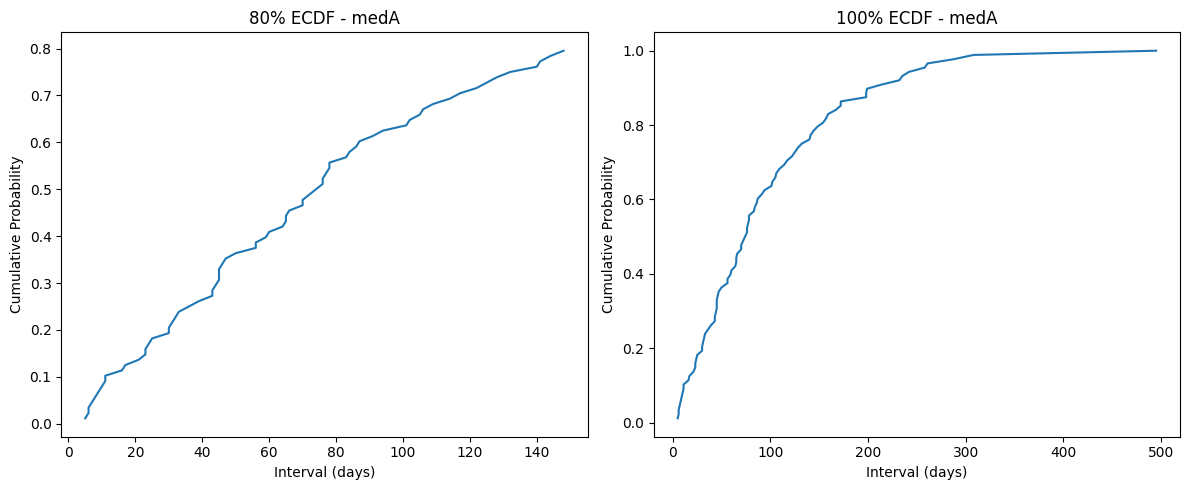

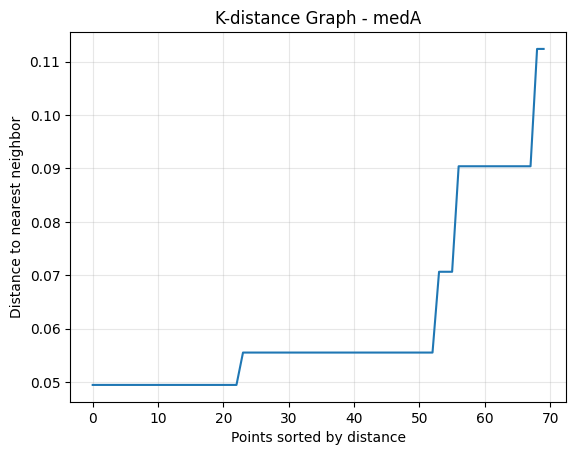

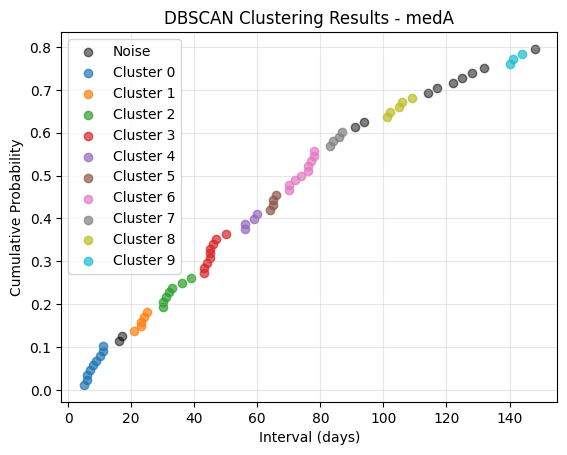

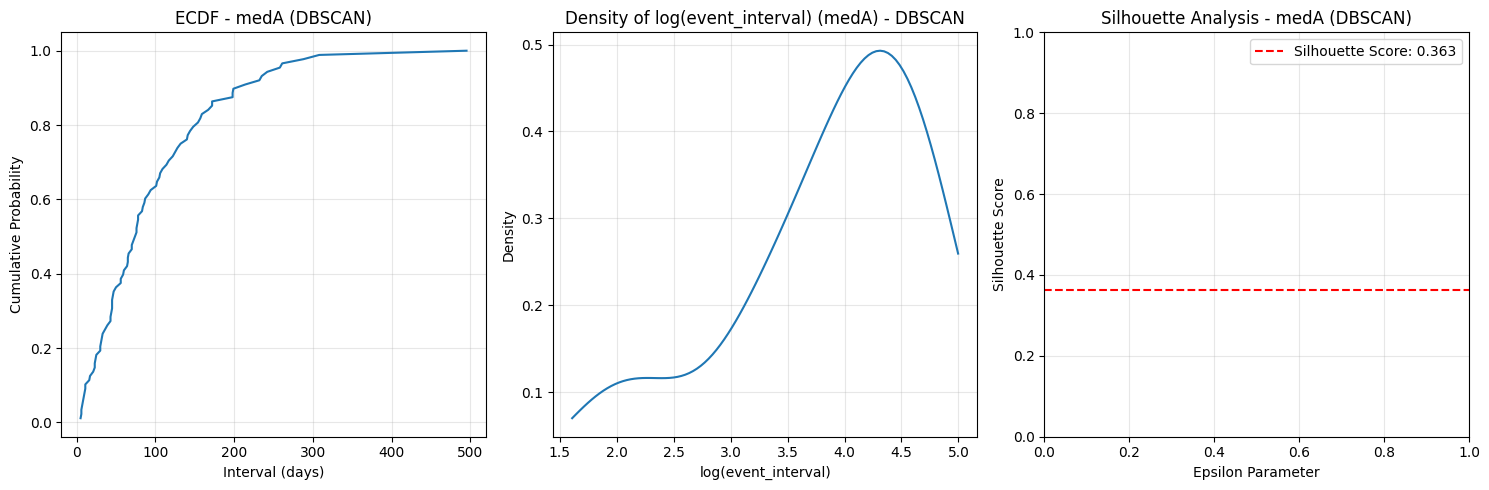


DBSCAN Results for medA:
Estimated number of clusters: 11
Estimated number of noise points: 11
Epsilon used: 0.090


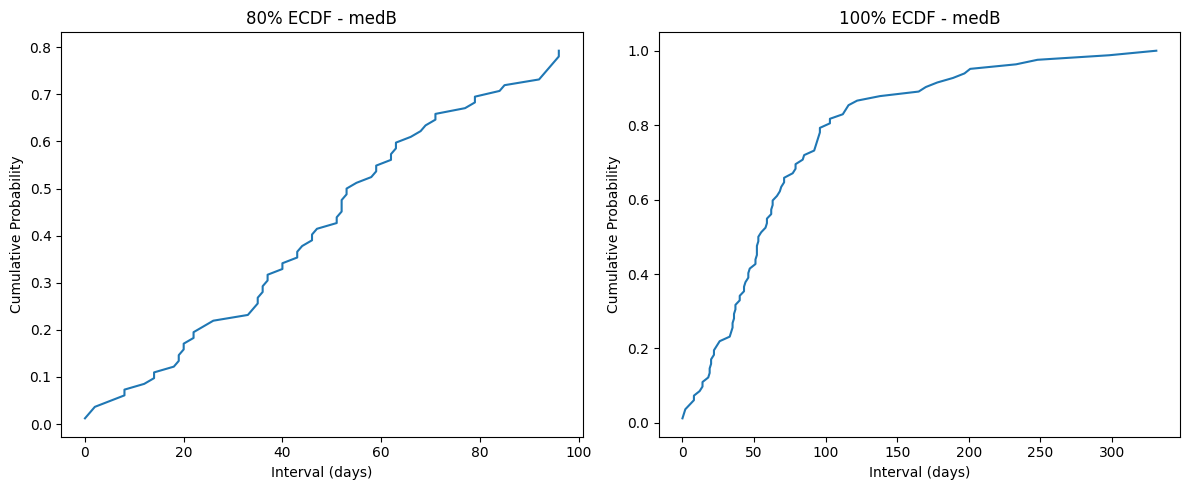

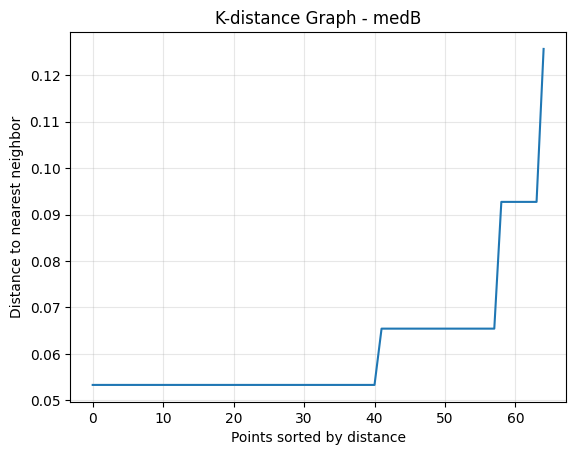

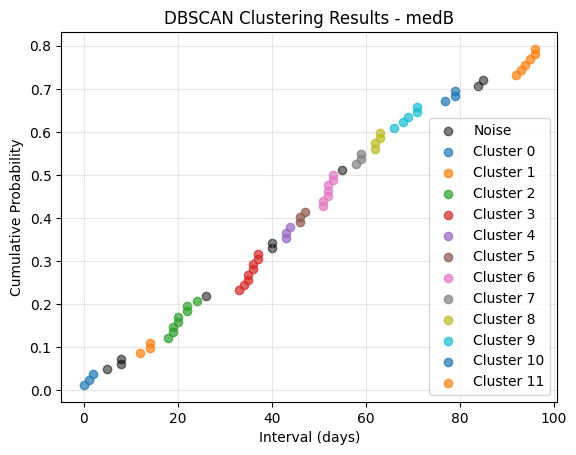

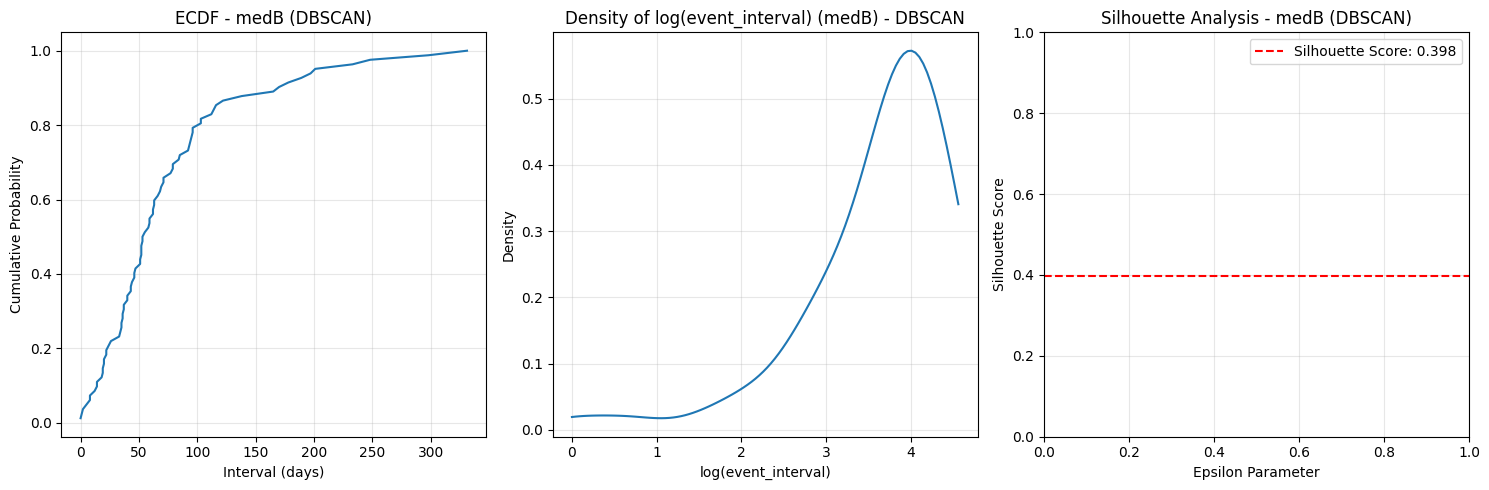


DBSCAN Results for medB:
Estimated number of clusters: 13
Estimated number of noise points: 9
Epsilon used: 0.093


In [21]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Load data
tidy = pd.read_csv("Data/med_events.csv")
tidy.columns = ["pnr", "eksd", "perday", "ATC", "dur_original"]
tidy['eksd'] = pd.to_datetime(tidy['eksd'], format='%m/%d/%Y')

def plot_dbscan_clustering(data_scaled, arg1, dfper, labels, x_vals, y_vals):
    """
    Plotting function for DBSCAN method: ECDF, Density, and Silhouette
    """
    plt.figure(figsize=(15, 5))
    
    # Plot ECDF
    plt.subplot(1, 3, 1)
    plt.plot(x_vals, y_vals)
    plt.title(f"ECDF - {arg1} (DBSCAN)")
    plt.xlabel("Interval (days)")
    plt.ylabel("Cumulative Probability")
    plt.grid(True, alpha=0.3)
    
    # Plot Density
    plt.subplot(1, 3, 2)
    # Add small constant and filter out non-positive values before log transform
    positive_intervals = dfper['x'][dfper['x'] > 0]
    if len(positive_intervals) > 0:
        log_intervals = np.log(positive_intervals)
        kde = gaussian_kde(log_intervals)
        x_range = np.linspace(log_intervals.min(), log_intervals.max(), 100)
        plt.plot(x_range, kde(x_range))
    plt.title(f'Density of log(event_interval) ({arg1}) - DBSCAN')
    plt.xlabel('log(event_interval)')
    plt.ylabel('Density')
    plt.grid(True, alpha=0.3)
    
    # Plot Silhouette
    plt.subplot(1, 3, 3)
    # Calculate silhouette score for DBSCAN result
    if len(set(labels)) > 1 and -1 not in labels:  # Only if we have valid clusters
        silhouette_avg = silhouette_score(data_scaled, labels)
        plt.axhline(y=silhouette_avg, color='r', linestyle='--',
                   label=f'Silhouette Score: {silhouette_avg:.3f}')
        plt.legend()
    
    plt.title(f"Silhouette Analysis - {arg1} (DBSCAN)")
    plt.xlabel("Epsilon Parameter")
    plt.ylabel("Silhouette Score")
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def See_dbscan(arg1="medA"):
    # Filter data for specific medication
    drug_see = tidy[tidy['ATC'] == arg1].copy()
    
    # Calculate intervals between prescriptions for each patient
    drug_see['prev_eksd'] = drug_see.groupby('pnr')['eksd'].shift(1)
    drug_see = drug_see.dropna(subset=['prev_eksd'])
    
    # Sample one interval per patient (simpler version)
    drug_see_sample = pd.DataFrame()
    for _, group in drug_see.groupby('pnr'):
        drug_see_sample = pd.concat([drug_see_sample, group.sample(n=1)])
    
    # Calculate interval in days
    drug_see_sample['event_interval'] = (
        drug_see_sample['eksd'] - drug_see_sample['prev_eksd']
    ).dt.days
    
    # Generate ECDF
    intervals = np.sort(drug_see_sample['event_interval'])
    n = len(intervals)
    y_vals = np.arange(1, n + 1) / n
    x_vals = intervals
    
    # Retain only 80% of the ECDF
    mask_80 = y_vals <= 0.8
    x_80 = x_vals[mask_80]
    y_80 = y_vals[mask_80]
    
    # Plot ECDFs
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(x_80, y_80)
    plt.title(f"80% ECDF - {arg1}")
    plt.xlabel("Interval (days)")
    plt.ylabel("Cumulative Probability")
    
    plt.subplot(1, 2, 2)
    plt.plot(x_vals, y_vals)
    plt.title(f"100% ECDF - {arg1}")
    plt.xlabel("Interval (days)")
    plt.ylabel("Cumulative Probability")
    
    plt.tight_layout()
    plt.show()
    
    # Prepare data for clustering
    dfper = pd.DataFrame({'x': x_vals, 'y': y_vals})
    dfper = dfper[dfper['y'] <= 0.8]  # Keep only 80% of data
    
    # Scale the data
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(dfper)
    
    # Find optimal epsilon using nearest neighbors
    neighbors = NearestNeighbors(n_neighbors=2)
    neighbors_fit = neighbors.fit(data_scaled)
    distances, indices = neighbors_fit.kneighbors(data_scaled)
    distances = np.sort(distances[:, 1])
    
    # Plot k-distance graph
    plt.figure()
    plt.plot(range(len(distances)), distances)
    plt.title(f'K-distance Graph - {arg1}')
    plt.xlabel('Points sorted by distance')
    plt.ylabel('Distance to nearest neighbor')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Use elbow method to find epsilon
    knee = np.diff(distances, 2)
    epsilon = distances[np.argmax(knee)]
    
    # Apply DBSCAN
    dbscan = DBSCAN(eps=epsilon, min_samples=3)
    dfper['cluster'] = dbscan.fit_predict(data_scaled)
    
    # Plot clustered data
    plt.figure()
    # Plot noise points (-1) in black
    noise = dfper[dfper['cluster'] == -1]
    plt.scatter(noise['x'], noise['y'], c='black', label='Noise', alpha=0.5)
    
    # Plot clusters
    for cluster in sorted(set(dfper['cluster'][dfper['cluster'] != -1])):
        cluster_data = dfper[dfper['cluster'] == cluster]
        plt.scatter(cluster_data['x'], cluster_data['y'], 
                   label=f'Cluster {cluster}', alpha=0.7)
    
    plt.title(f'DBSCAN Clustering Results - {arg1}')
    plt.xlabel('Interval (days)')
    plt.ylabel('Cumulative Probability')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Use plotting function
    plot_dbscan_clustering(
        data_scaled, arg1, dfper, dfper['cluster'], x_vals, y_vals
    )
    
    # Print clustering statistics
    n_clusters = len(set(dfper['cluster'])) - (1 if -1 in dfper['cluster'] else 0)
    n_noise = list(dfper['cluster']).count(-1)
    print(f"\nDBSCAN Results for {arg1}:")
    print(f"Estimated number of clusters: {n_clusters}")
    print(f"Estimated number of noise points: {n_noise}")
    print(f"Epsilon used: {epsilon:.3f}")
    
    return max(x_80), dfper

# Run DBSCAN clustering analysis
print("DBSCAN Clustering Analysis")
print("\nRunning DBSCAN analysis...")
max_interval_medA_dbscan, clusters_medA_dbscan = See_dbscan("medA")
max_interval_medB_dbscan, clusters_medB_dbscan = See_dbscan("medB")

## Comparison of Sessa Empircal Estimator vs Clustering Algorithm (DBSCAN)

Generating clustering comparison...

Getting K-means results for comparison...

Getting DBSCAN results for comparison...

Comparing clustering methods...


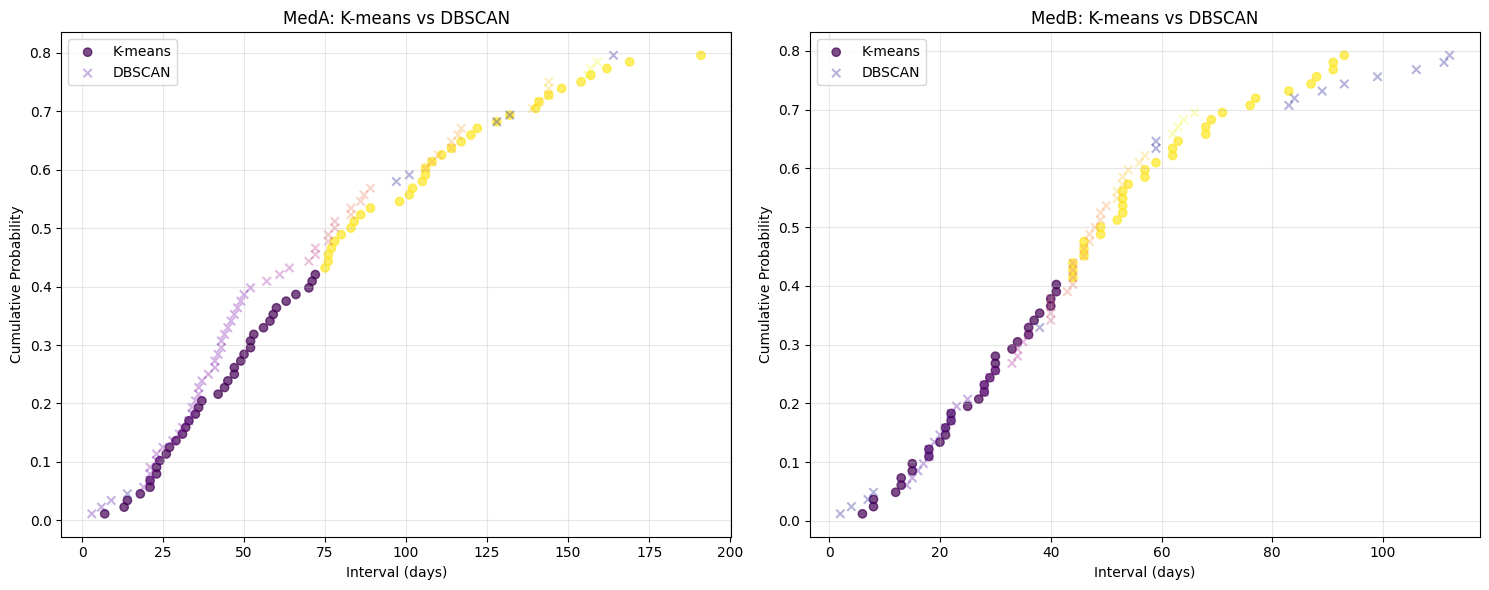

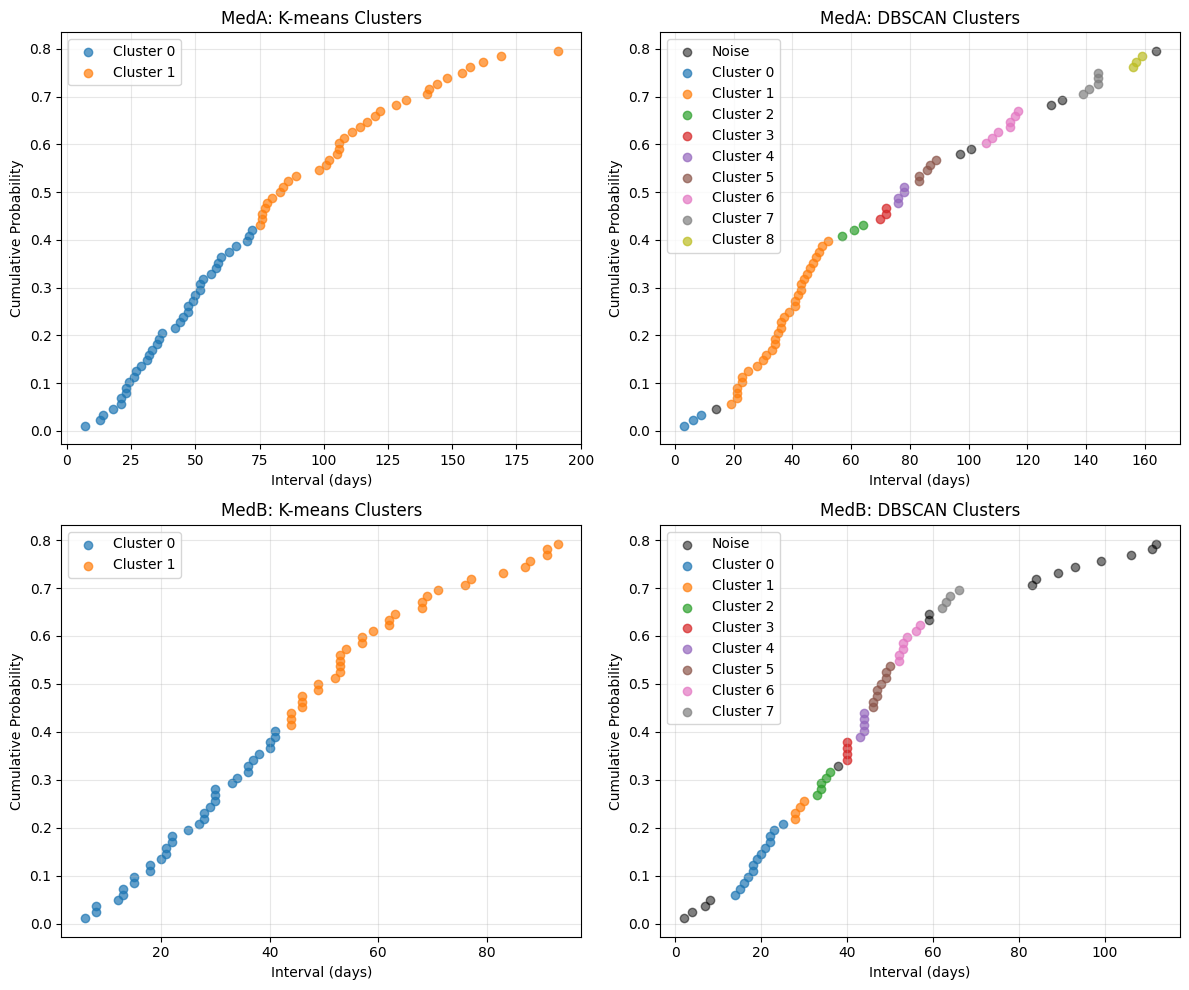

In [22]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# Load data
tidy = pd.read_csv("Data/med_events.csv")
tidy.columns = ["pnr", "eksd", "perday", "ATC", "dur_original"]
tidy['eksd'] = pd.to_datetime(tidy['eksd'], format='%m/%d/%Y')

def get_kmeans_clusters(arg1="medA"):
    """Get K-means clustering results for comparison"""
    # Filter data for specific medication
    drug_see = tidy[tidy['ATC'] == arg1].copy()
    
    # Calculate intervals between prescriptions for each patient
    drug_see['prev_eksd'] = drug_see.groupby('pnr')['eksd'].shift(1)
    drug_see = drug_see.dropna(subset=['prev_eksd'])
    
    # Sample one interval per patient
    drug_see_sample = pd.DataFrame()
    for _, group in drug_see.groupby('pnr'):
        drug_see_sample = pd.concat([drug_see_sample, group.sample(n=1)])
    
    # Calculate interval in days
    drug_see_sample['event_interval'] = (
        drug_see_sample['eksd'] - drug_see_sample['prev_eksd']
    ).dt.days
    
    # Generate ECDF
    intervals = np.sort(drug_see_sample['event_interval'])
    n = len(intervals)
    y_vals = np.arange(1, n + 1) / n
    x_vals = intervals
    
    # Prepare data for clustering
    dfper = pd.DataFrame({'x': x_vals, 'y': y_vals})
    dfper = dfper[dfper['y'] <= 0.8]  # Keep only 80% of data
    
    # Scale the data
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(dfper)
    
    # Find optimal number of clusters using silhouette score
    range_n_clusters = range(2, 11)
    silhouette_scores = []
    best_score = -1
    best_n_clusters = 2
    
    for n_clusters in range_n_clusters:
        kmeans = KMeans(n_clusters=n_clusters, random_state=1234)
        cluster_labels = kmeans.fit_predict(data_scaled)
        silhouette_avg = silhouette_score(data_scaled, cluster_labels)
        silhouette_scores.append(silhouette_avg)
        
        if silhouette_avg > best_score:
            best_score = silhouette_avg
            best_n_clusters = n_clusters
    
    # Apply K-means with optimal number of clusters
    kmeans = KMeans(n_clusters=best_n_clusters, random_state=1234)
    dfper['cluster'] = kmeans.fit_predict(data_scaled)
    
    return dfper

def get_dbscan_clusters(arg1="medA"):
    """Get DBSCAN clustering results for comparison"""
    # Filter data for specific medication
    drug_see = tidy[tidy['ATC'] == arg1].copy()
    
    # Calculate intervals between prescriptions for each patient
    drug_see['prev_eksd'] = drug_see.groupby('pnr')['eksd'].shift(1)
    drug_see = drug_see.dropna(subset=['prev_eksd'])
    
    # Sample one interval per patient
    drug_see_sample = pd.DataFrame()
    for _, group in drug_see.groupby('pnr'):
        drug_see_sample = pd.concat([drug_see_sample, group.sample(n=1)])
    
    # Calculate interval in days
    drug_see_sample['event_interval'] = (
        drug_see_sample['eksd'] - drug_see_sample['prev_eksd']
    ).dt.days
    
    # Generate ECDF
    intervals = np.sort(drug_see_sample['event_interval'])
    n = len(intervals)
    y_vals = np.arange(1, n + 1) / n
    x_vals = intervals
    
    # Prepare data for clustering
    dfper = pd.DataFrame({'x': x_vals, 'y': y_vals})
    dfper = dfper[dfper['y'] <= 0.8]  # Keep only 80% of data
    
    # Scale the data
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(dfper)
    
    # Find optimal epsilon using nearest neighbors
    neighbors = NearestNeighbors(n_neighbors=2)
    neighbors_fit = neighbors.fit(data_scaled)
    distances, indices = neighbors_fit.kneighbors(data_scaled)
    distances = np.sort(distances[:, 1])
    
    # Use elbow method to find epsilon
    knee = np.diff(distances, 2)
    epsilon = distances[np.argmax(knee)]
    
    # Apply DBSCAN
    dbscan = DBSCAN(eps=epsilon, min_samples=3)
    dfper['cluster'] = dbscan.fit_predict(data_scaled)
    
    return dfper

def compare_clustering_methods(medA_kmeans, medA_dbscan, medB_kmeans, medB_dbscan):
    """
    Compare K-means and DBSCAN results visually
    """
    # Side-by-side comparison plots
    plt.figure(figsize=(15, 6))
    
    # Plot MedA comparison
    plt.subplot(1, 2, 1)
    plt.scatter(medA_kmeans['x'], medA_kmeans['y'], c=medA_kmeans['cluster'], 
               cmap='viridis', alpha=0.7, label='K-means')
    plt.scatter(medA_dbscan['x'], medA_dbscan['y'], c=medA_dbscan['cluster'], 
               cmap='plasma', alpha=0.3, marker='x', label='DBSCAN')
    plt.title('MedA: K-means vs DBSCAN')
    plt.xlabel('Interval (days)')
    plt.ylabel('Cumulative Probability')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot MedB comparison
    plt.subplot(1, 2, 2)
    plt.scatter(medB_kmeans['x'], medB_kmeans['y'], c=medB_kmeans['cluster'], 
               cmap='viridis', alpha=0.7, label='K-means')
    plt.scatter(medB_dbscan['x'], medB_dbscan['y'], c=medB_dbscan['cluster'], 
               cmap='plasma', alpha=0.3, marker='x', label='DBSCAN')
    plt.title('MedB: K-means vs DBSCAN')
    plt.xlabel('Interval (days)')
    plt.ylabel('Cumulative Probability')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
    
    # Individual method visualization for MedA
    plt.figure(figsize=(12, 10))
    
    # K-means clusters for MedA
    plt.subplot(2, 2, 1)
    for cluster in sorted(set(medA_kmeans['cluster'])):
        cluster_data = medA_kmeans[medA_kmeans['cluster'] == cluster]
        plt.scatter(cluster_data['x'], cluster_data['y'], 
                   label=f'Cluster {cluster}', alpha=0.7)
    plt.title('MedA: K-means Clusters')
    plt.xlabel('Interval (days)')
    plt.ylabel('Cumulative Probability')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # DBSCAN clusters for MedA
    plt.subplot(2, 2, 2)
    # Plot noise points (-1) in black
    noise = medA_dbscan[medA_dbscan['cluster'] == -1]
    if not noise.empty:
        plt.scatter(noise['x'], noise['y'], c='black', label='Noise', alpha=0.5)
    
    # Plot clusters
    for cluster in sorted(set(medA_dbscan['cluster'][medA_dbscan['cluster'] != -1])):
        cluster_data = medA_dbscan[medA_dbscan['cluster'] == cluster]
        plt.scatter(cluster_data['x'], cluster_data['y'], 
                   label=f'Cluster {cluster}', alpha=0.7)
    plt.title('MedA: DBSCAN Clusters')
    plt.xlabel('Interval (days)')
    plt.ylabel('Cumulative Probability')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Individual method visualization for MedB
    # K-means clusters for MedB
    plt.subplot(2, 2, 3)
    for cluster in sorted(set(medB_kmeans['cluster'])):
        cluster_data = medB_kmeans[medB_kmeans['cluster'] == cluster]
        plt.scatter(cluster_data['x'], cluster_data['y'], 
                   label=f'Cluster {cluster}', alpha=0.7)
    plt.title('MedB: K-means Clusters')
    plt.xlabel('Interval (days)')
    plt.ylabel('Cumulative Probability')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # DBSCAN clusters for MedB
    plt.subplot(2, 2, 4)
    # Plot noise points (-1) in black
    noise = medB_dbscan[medB_dbscan['cluster'] == -1]
    if not noise.empty:
        plt.scatter(noise['x'], noise['y'], c='black', label='Noise', alpha=0.5)
    
    # Plot clusters
    for cluster in sorted(set(medB_dbscan['cluster'][medB_dbscan['cluster'] != -1])):
        cluster_data = medB_dbscan[medB_dbscan['cluster'] == cluster]
        plt.scatter(cluster_data['x'], cluster_data['y'], 
                   label=f'Cluster {cluster}', alpha=0.7)
    plt.title('MedB: DBSCAN Clusters')
    plt.xlabel('Interval (days)')
    plt.ylabel('Cumulative Probability')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Get clustering results for comparison
print("Generating clustering comparison...")
print("\nGetting K-means results for comparison...")
clusters_medA_kmeans = get_kmeans_clusters("medA")
clusters_medB_kmeans = get_kmeans_clusters("medB")

print("\nGetting DBSCAN results for comparison...")
clusters_medA_dbscan = get_dbscan_clusters("medA")
clusters_medB_dbscan = get_dbscan_clusters("medB")

# Compare results
print("\nComparing clustering methods...")
compare_clustering_methods(
    clusters_medA_kmeans,
    clusters_medA_dbscan,
    clusters_medB_kmeans,
    clusters_medB_dbscan
)

# Comparison of K-Means vs. DBSCAN

## 1. Number of Clusters

### K-Means:
- Finds an optimal number of clusters using silhouette scores.
- For **medA**, the number of clusters is determined by the max silhouette score.
- For **medB**, the same approach applies.

### DBSCAN:
- Finds clusters based on density, using an automatically determined epsilon from the k-distance graph.
- It may detect more natural clusters compared to K-Means but can also label many points as noise (`-1` cluster).

### 📌 Key Difference:
- **K-Means** forces data into clusters even if there isn’t a natural grouping.
- **DBSCAN** identifies dense clusters but can leave outliers as noise.

---

## 2. Handling of Noise & Outliers

### K-Means:
- Assigns every data point to a cluster, even if it doesn’t belong.
- This can misrepresent sparse or noisy data by forcing an artificial grouping.

### DBSCAN:
- Identifies and ignores noise points (points labeled as `-1`).
- If a medication’s event intervals have irregular patterns, DBSCAN may flag more noise.

### 📌 Key Difference:
- **DBSCAN** handles outliers better by not forcing every point into a cluster.
- **K-Means** assumes clusters exist even if they don’t naturally form.

---

## 3. Cluster Shape and Distribution

### K-Means:
- Creates **spherical, evenly sized clusters** due to Euclidean distance.
- Works well if the data is normally distributed and has distinct groups.

### DBSCAN:
- Forms **clusters of arbitrary shapes** (not necessarily circular).
- Useful for complex distributions but depends on a good epsilon value.

### 📌 Key Difference:
- **K-Means** struggles with non-spherical clusters.
- **DBSCAN** is better for clusters with varying shapes.

---

## 4. Silhouette Scores (Cluster Quality)

### K-Means:
- The silhouette score is calculated across multiple cluster numbers (2-10).
- The best cluster count is chosen based on the highest silhouette score.

### DBSCAN:
- Only evaluates silhouette score if valid clusters exist (not just noise).
- Since DBSCAN may label many points as noise, the silhouette score may not always be available.

### 📌 Key Difference:
- **K-Means** guarantees a silhouette score and an optimal cluster number.
- **DBSCAN** may not always provide a valid score due to its noise filtering.

---

## 5. Medication-Specific Observations

### For **medA**:
- **K-Means** produced structured clusters.
- **DBSCAN** might have labeled some points as noise, leading to fewer clusters.

### For **medB**:
- If intervals were irregular, **DBSCAN** detected noise more aggressively than for **medA**.
- **K-Means** still grouped everything into artificial clusters.
